# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [23]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import spacy
nlp=spacy.load('en_core_web_sm')
from tqdm import tqdm
from bs4 import BeautifulSoup
import os
#os.chdir('C:\\Users\\prudi\\Desktop\\Data Sets\\amazon-fine-food-reviews')
os.chdir('C:\\Users\\Administrator\\Desktop\\Data\\AmazonFineFood\\database.sqlite')

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data {shape} and rows {0}, columns {1}".format(filtered_data.shape[0],filtered_data.shape[1],shape=filtered_data.shape))


Number of data points in our data (5000, 10) and rows 5000, columns 10


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

In [17]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [176]:
final_1=final[0:500]
final_1.shape

(500, 11)

In [177]:
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
def keep_token(t):
    return (t.is_alpha and 
            not (t.is_space or t.is_punct or 
                 t.is_stop or t.like_num))

def lemmatize_doc(doc):
    lemmatied_words=[t.lemma_ for t in doc if keep_token(t)]
    return ' '.join([text for text in lemmatied_words])

def porter_stemmer_1(doc):
    words=nltk.word_tokenize(doc)
    words=[stemmer.stem(word) for word in words]
    return words

# This is not working
def porter_stemmer_1(doc):
    return [stemmer.stem(doc[t]) for t in range(len(doc)) if keep_token(doc[t])]

final_1['Preprocessed_Text'] = [lemmatize_doc((nlp(doc))) for doc in final_1['Text']]


In [178]:
final.iloc[0:1,9:10]

,Text
2546,Why is this $[...] when the same product is av...


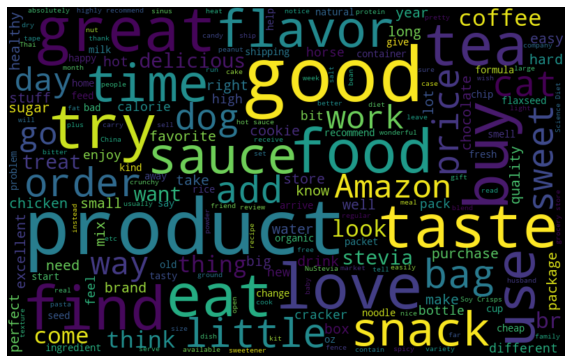

In [179]:
all_words = ' '.join([text for text in final_1['Preprocessed_Text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

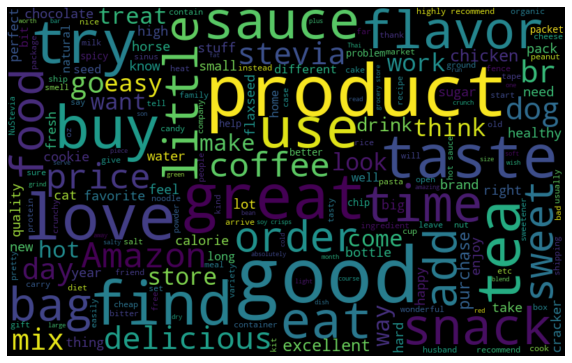

In [180]:
normal_words =' '.join([text for text in final_1['Preprocessed_Text'][final_1['Score'] == 1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

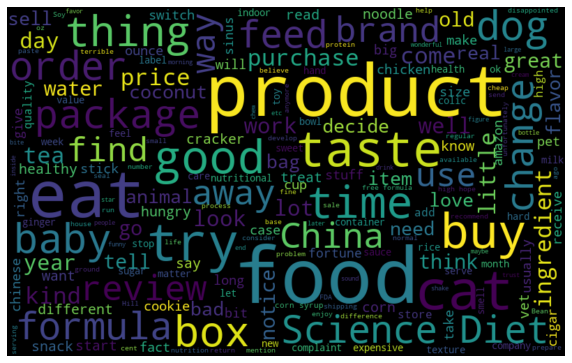

In [181]:
negative_words =' '.join([text for text in final_1['Preprocessed_Text'][final_1['Score'] == 0]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [205]:
import os
office='C:\\Users\\Administrator\\Documents\\GitHub\\Code\\2019\\SPACY'
os.chdir(office)

with open('TextData.txt', encoding="utf8") as file:
    long_description = file.read()
    document = nlp(long_description)

In [189]:
document=nlp(all_words)
labels = set([w.label_ for w in document.ents]) 
for label in labels: 
    entities = [e.string for e in document.ents if label==e.label_] 
    entities = list(set(entities)) 
    print(label,entities)
    print('*'*150)

ORDINAL ['fourth ', 'tenth ', 'second ']
******************************************************************************************************************************************************
NORP ['Gluten ', 'TALK ', 'Crunch ', 'Pharmacist ', 'Thai ', 'Thia ', 'Pica Mexican ', 'TEA SERIOUSLY ', 'american ', 'French ', 'Marines ', 'Italians ', 'Chili ', 'Chinese ', 'African ', 'Almond Crunch ', 'Americans ', 'Organic ', 'Felidae ', 'Cashew Crunch ', 'Carbs ', 'Perugina ', 'Mmmmmmmm ', 'Items ']
******************************************************************************************************************************************************
LOC ['Nustevia Nustevia ', 'Mochi Cakes ', 'Seeds China ', 'Earth ', 'Southern California ', 'South Florida ', 'Forget Starbucks Peets ', 'Flavors California ', 'Trader Joe ', 'Masaman ', 'Europe ', 'Pico Pica ']
****************************************************************************************************************************************

******************************************************************************************************************************************************
DATE ['exclusively year ', 'month normal year ', 'couple day ', 'formula week ago ', 'tomorrow ', 'year half old ', 'ice summer ', 'year old ', 'week ', 'start day ', 'summer day ', 'hundred year ', 'Christmas Christmas Eve Christmas ', 'sinus day later ', 'February ', 'tea year ago ', 'almond week ', 'past year ', 'year ', 'last year ', 'March ', 'discover year ago ', 'couple month ago ', 'Maltodextrin month ago ', 'tea day ', 'year ago ', 'birthday year old ', 'day ', 'season ', 'winter month ', 'winter ', 'last month ', 'blob month ', 'dust year ago ', 'tablespoon day ', 'NuStevia year ago ', 'couple year ago ', 'number year ', 'one year ', 'daily ', 'month ', 'Christmas ', 'nearly month ', 'weekly ', 'smoothie day ', 'refrigerator month ', 'flaxseed year ', 'week ago ', 'try month ago ', 'bud year ']
*********************************

## Dependency Parsing

In [219]:
hotel = [sent for sent in document.sents if 'hotel' in sent.string.lower()]
print(hotel[2])
for word in hotel[2]:
    print(word,': ',str(list(word.children)))

A cab from the airport to the hotel can be cheaper than the shuttles depending what time of the day you go.
A :  []
cab :  [A, from]
from :  [airport, to]
the :  []
airport :  [the]
to :  [hotel]
the :  []
hotel :  [the]
can :  []
be :  [cab, can, cheaper, .]
cheaper :  [than]
than :  [shuttles]
the :  []
shuttles :  [the, depending]
depending :  [time]
what :  []
time :  [what, of]
of :  [day]
the :  []
day :  [the, go]
you :  []
go :  [you]
. :  []


In [231]:
from nltk import Tree
def tok_format(tok):
    return "_".join([tok.orth_, tok.tag_, tok.dep_])


def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(tok_format(node), [to_nltk_tree(child) for child in node.children])
    else:
        return tok_format(node)


command = "Submit debug logs to project lead today at 9:00 AM"
en_doc = nlp(u'' + command) 

[to_nltk_tree(sent.root).pretty_print() for sent in en_doc.sents]

               Submit_VB_ROOT                                 
                     |                                         
               logs_VBZ_dobj                                  
       ______________|________________________________         
      |              |            to_TO_prep      at_IN_prep  
      |              |                |               |        
      |              |           lead_NN_pobj     AM_NN_pobj  
      |              |                |               |        
debug_NN_amod today_NN_npadvmo project_VB_compo 9:00_CD_nummod
                     d               und                      



[None]